# Predict Next Product-category-to-buy

<u>Table of Contents</u>

1 [Exploratory Data Analysis](#EDA)

- 1.1 [Overall Sales Performance](#Overall)
    
- 1.2 [Customer Purchase Pattern](#Order)

- 1.3 [Customer Online Visit](#Online)

- 1.4 [Customer Segmentation](#CustSeg)

2 [Feature Engineering](#F-eng)

3 [Modeling](#Modeling)
    
- 3.1 [Design & Sampling](#M-design)
    
- 3.2 [Generation, Iteration & Feature Selection](#M-gen)
    
- 3.3 [Evaluation Across Models](#M-eval)

4 [Summary of Results](#Summary)

<a id='Online'></a>

## 1 Exploratory data analysis  <a id='EDA'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("max_columns", 999)

#### Order dataset

In [2]:
order = pd.read_csv('data/order.csv')

In [3]:
order.shape

(263278, 6)

In [6]:
order.dtypes

custno         int64
ordno          int64
orderdate     object
prodcat2     float64
prodcat1       int64
revenue      float64
dtype: object

In [8]:
order['year'] = order.orderdate.astype(np.datetime64).dt.year
order['month'] = order.orderdate.astype(np.datetime64).dt.month
order['year_month'] = order.orderdate.astype(np.datetime64).dt.to_period('M')

In [31]:
order.head(3)

,custno,ordno,orderdate,prodcat2,prodcat1,revenue,year,month,year_month
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30,2016,11,2016-11
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10,2017,4,2017-04
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66,2017,4,2017-04


##### The dataset includes the orders from January 2016 to January 2019.

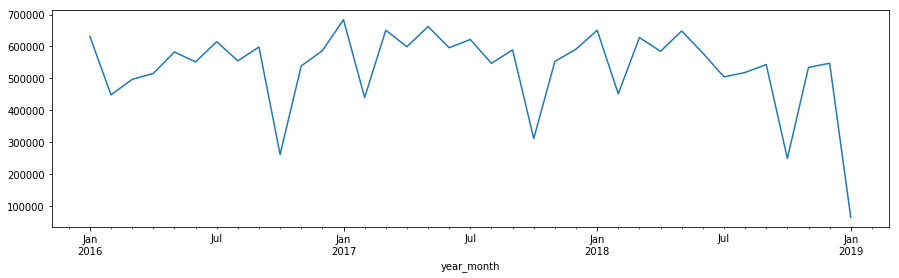

In [578]:
plt.figure(figsize=(15,4))
order.groupby('year_month').revenue.sum().plot()

In [99]:
print('Earliest data point:',order.orderdate.min())
print('Latest data point:',order.orderdate.max())

Earliest data point: 2016-01-01 05:05:14
Latest data point: 2019-01-02 23:54:58


In [44]:
print('In total,',order.ordno.nunique(),'orders')
print('with',order.ordno.count(),'product items')
print('purchased by',order.custno.nunique(),'customers')
print('bringing in',round(order.revenue.sum(),0),'revenue')

In total, 149717 orders
with 263278 product items
purchased by 70264 customers
bringing in 19729870.0 revenue


## 1.1 Overall Sales Performance  <a id='Overall'></a>

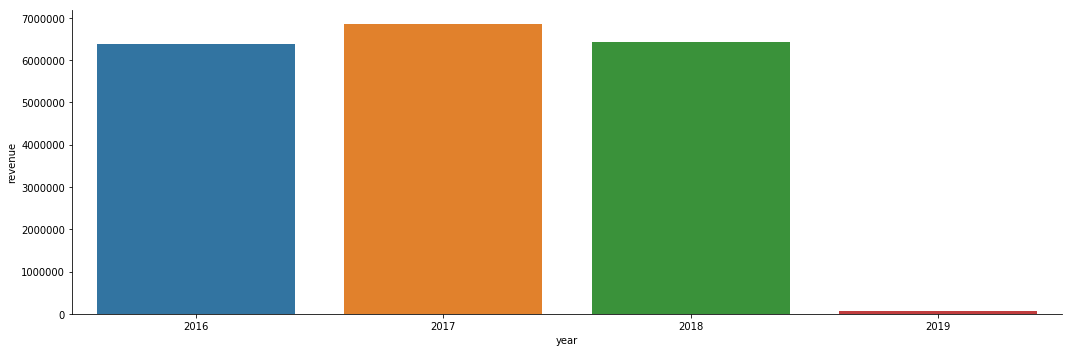

In [812]:
temp = order.groupby(['year']).revenue.agg(['count','sum']).reset_index().rename(columns={'sum':'revenue'})
sns.catplot(data=temp, x='year', y= 'revenue', kind='bar', aspect=3)

##### Is there a shift in purchased product categories?

### Revenue for prodcat 2 is dropping; meanwhile, 3 and 7 are growing 

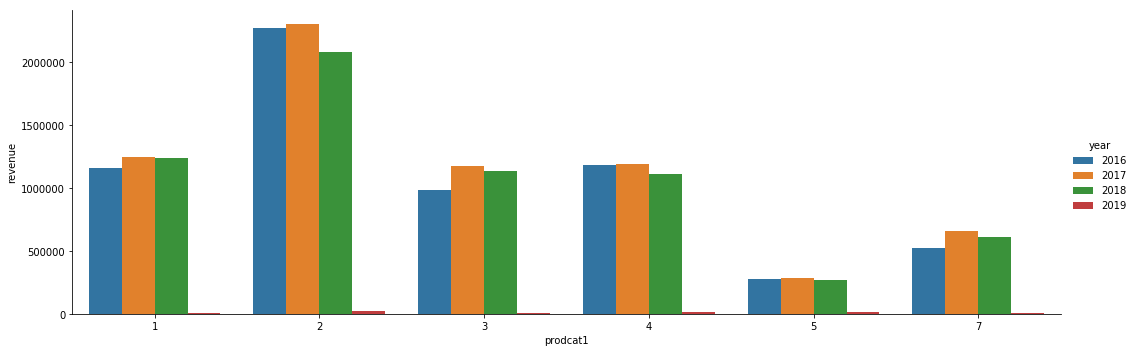

In [813]:
temp2 = order.groupby(['year','prodcat1']).revenue.agg(['count','sum']).reset_index().rename(columns={'sum':'revenue'})
sns.catplot(data=temp2, x='prodcat1', y= 'revenue', hue= 'year', kind='bar', aspect=3)

### Purchase season peaked in January and fell in Octobe; demands in March to May raised in recent two years.

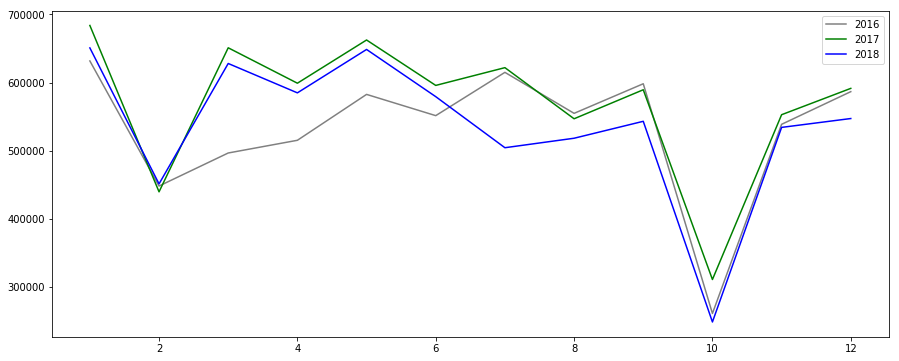

In [448]:
temp = order.groupby(['year','month']).revenue.agg(['count','sum']).reset_index()
plt.figure(figsize=(15,6))
plt.plot(temp[temp.year==2016]['month'], temp[temp.year==2016]['sum'], 'grey', label="2016")
plt.plot(temp[temp.year==2017]['month'], temp[temp.year==2017]['sum'], 'green', label="2017")
plt.plot(temp[temp.year==2018]['month'], temp[temp.year==2018]['sum'], 'blue', label="2018")
#plt.plot(temp[temp.year==2019]['month'], temp[temp.year==2019]['sum'], 'red', label="2019")
plt.legend()

### Category 1 has a peak in November; 2 is all time high, except for October to December.

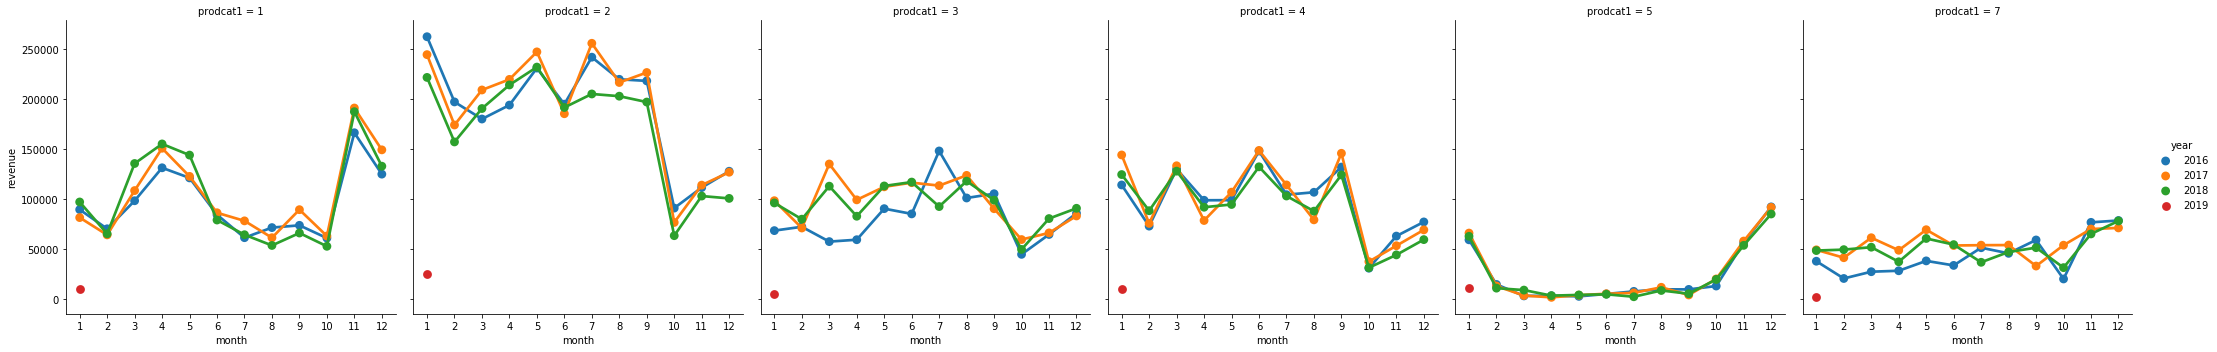

In [815]:
temp = order.groupby(['year','month','prodcat1']).revenue.agg(['count','sum']).reset_index().rename(columns={'sum':'revenue'})
sns.catplot(data=temp, x='month', y='revenue', hue='year', col='prodcat1', kind='point', aspect=1)

### Purchased items per order: 61% contained one item; 28% contained two; 8% contained three.

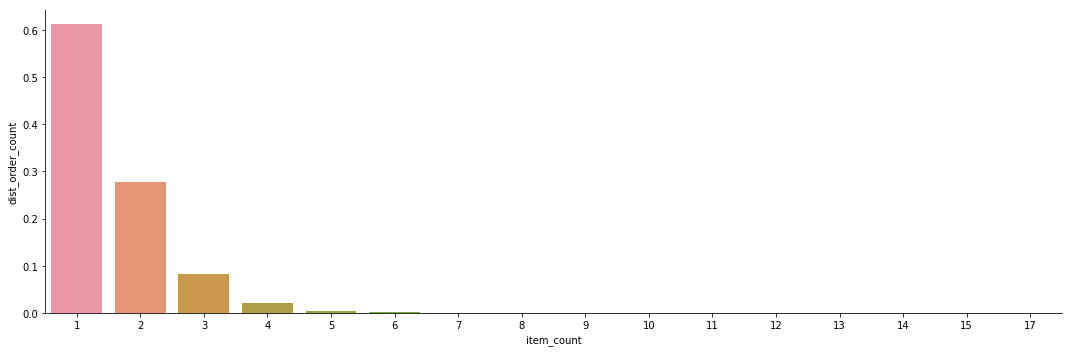

In [816]:
temp = order_T.groupby('count').ordno.count().reset_index().rename(columns={'count':'item_count','ordno':'order_count'})
temp['dist_order_count'] = temp['order_count'] / temp['order_count'].sum()
#temp
sns.catplot(data=temp, x='item_count', y='dist_order_count', kind='bar', aspect=3)

## 1.2 Customer Purchase Pattern <a id='Order'></a>

### Is there a preferred combination of product purchased?

80% of the orders contains only one product category; 

In [520]:
df = order.groupby(['custno','ordno','orderdate','year','prodcat1']).revenue.agg(['count','sum']).reset_index()
df = pd.get_dummies(df,columns=['prodcat1'])
order_T = df.groupby(['ordno','custno','orderdate']).max().reset_index()
#print(order_T.shape)
order_T.head(3)

,ordno,custno,orderdate,year,count,sum,prodcat1_1,prodcat1_2,prodcat1_3,prodcat1_4,prodcat1_5,prodcat1_7
0,1,1,2017-06-12 08:27:59,2017,1,8.35,1,0,0,0,0,0
1,2,2,2016-03-29 13:04:27,2016,1,13.58,1,0,0,0,0,0
2,3,3,2017-01-31 19:16:49,2017,1,95.76,1,0,0,0,0,0


In [521]:
temp = order_T.groupby(['prodcat1_1','prodcat1_2','prodcat1_3','prodcat1_4','prodcat1_5','prodcat1_7']). \
ordno.count().to_frame().rename(columns={'ordno':'order_cnt'}).sort_values(ascending=False, by='order_cnt').reset_index()
temp['order_distribution'] = round(temp['order_cnt'] / temp['order_cnt'].sum(),3)
temp['order_distribution_cummulative'] = temp['order_distribution'].cumsum()
#temp.head(15)

In [522]:
order_T['product_comb'] = order_T['prodcat1_1'].apply(lambda x: str(x*1) if x >0 else '') \
                        + order_T['prodcat1_2'].apply(lambda x: str(x*2) if x >0 else '') \
                        + order_T['prodcat1_3'].apply(lambda x: str(x*3) if x >0 else '') \
                        + order_T['prodcat1_4'].apply(lambda x: str(x*4) if x >0 else '') \
                        + order_T['prodcat1_5'].apply(lambda x: str(x*5) if x >0 else '') \
                        + order_T['prodcat1_7'].apply(lambda x: str(x*7) if x >0 else '')

In [556]:
temp = order_T.groupby(['product_comb']). \
ordno.count().to_frame().rename(columns={'ordno':'order_cnt'}).sort_values(ascending=False, by=['order_cnt']).reset_index()
temp['ttl_order'] = temp['order_cnt'].sum()
temp['order_distribution'] = temp['order_cnt'] / temp['ttl_order']
temp['order_distribution_cummulative'] = temp['order_distribution'].cumsum()
#temp.head(15)

### Over 80% of the orders contained only one product category: category 2 is the most; 1, 3 and 4 comes after.

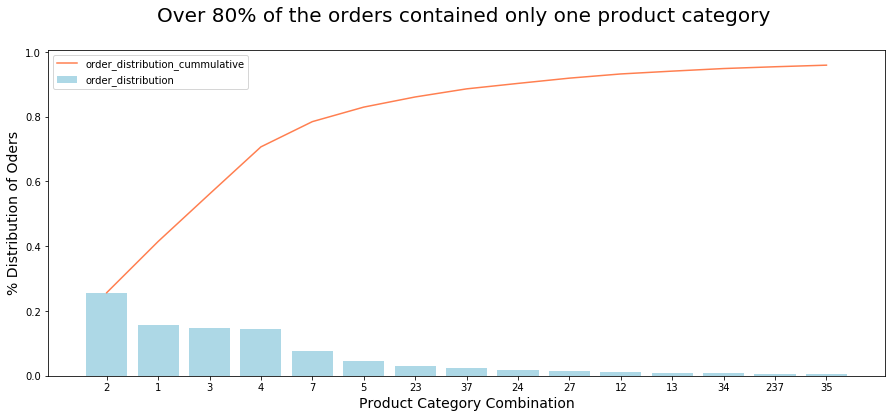

In [524]:
#x = ['2','1','3','4','7','5','2+3','3+7','2+4','2+7','1+2','1+3','3+4','2+3+7','3+5']
x = [i for i in temp['product_comb'][:15] ]
y = [i for i in temp['order_distribution'][:15] ]
y2 = [i for i in temp['order_distribution_cummulative'][:15] ]

plt.figure(figsize=(15,6))
plt.bar(x, y, color='lightblue', label='order_distribution')
plt.plot(x, y2, color='coral', label='order_distribution_cummulative')

plt.title('Over 80% of the orders contained only one product category \n ', fontsize=20)
plt.xlabel('Product Category Combination', fontsize=14)
plt.ylabel('% Distribution of Oders', fontsize=14)
plt.legend()

Customers' purchased combination is quite stable across years.

In [525]:
temp = order_T.groupby(['year','product_comb']). \
ordno.count().to_frame().rename(columns={'ordno':'order_cnt'}).sort_values(ascending=False, by=['year','order_cnt']).reset_index()
temp['ttl_order_by_year'] = temp.groupby('year')['order_cnt'].transform('sum')
temp['order_distribution'] = temp['order_cnt'] / temp['ttl_order_by_year']
#temp.groupby('year').order_distribution.sum()

### Purchased category combination did not shift much overtime; however, category 2 trends down, 3+7 goes up.

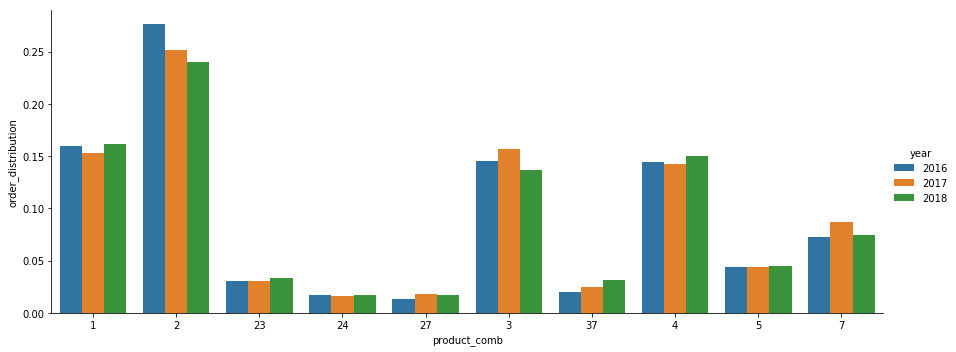

In [526]:
temp2 = temp[(temp['product_comb'].isin(['2','1','3','4','7','5','23','37','24','27'])) & (temp.year != 2019)]
sns.catplot(data=temp2, x='product_comb', y='order_distribution', hue='year', kind='bar', aspect=2.5)

## New vs. Existing Customers

In [529]:
order_T['ord_no_by_cust'] = 1
order_T['ord_no_by_cust'] = order_T.sort_values(by='orderdate').groupby('custno')['ord_no_by_cust'].cumsum()
order_T['new_cust_f'] = order_T['ord_no_by_cust'].apply(lambda x: 1 if x == 1 else 0)
order_T['first_buy_year'] = order_T.groupby('custno').year.transform('min')
order_T['new_cust_by_year'] = (order_T['year'] == order_T['first_buy_year'])*1

### Each year, new comers accounts for over 80% of the customers and contributed over 50% of the revenue.

Number of Customers who ordered - New (1) vs. Existing (0) Customers

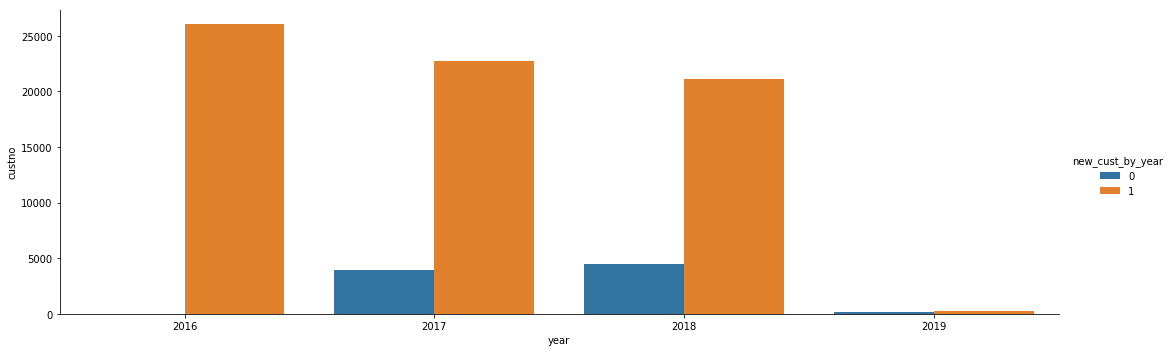

In [817]:
temp = order_T.groupby(['year','new_cust_by_year'])['custno'].nunique().to_frame().reset_index()
sns.catplot(data=temp, x='year', y='custno', kind='bar', hue='new_cust_by_year', aspect=3)

Revenue - New (1) vs. Existing (0) Customers

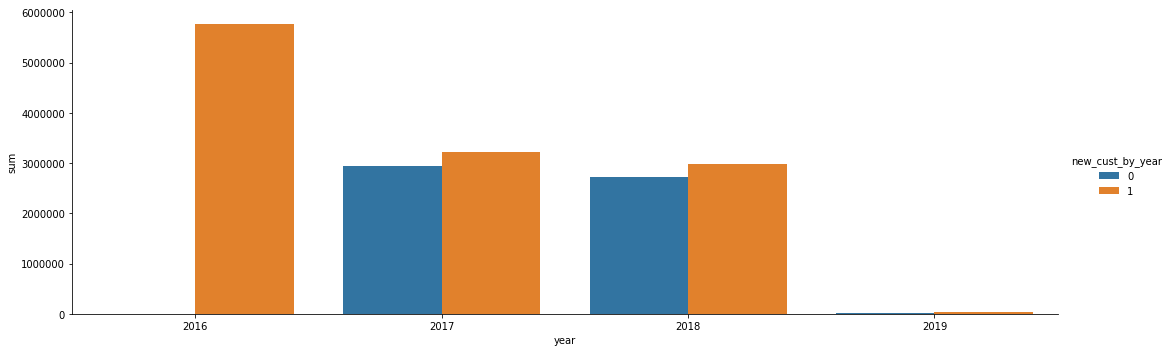

In [818]:
temp = order_T.groupby(['year','new_cust_by_year'])['sum'].sum().to_frame().reset_index()
sns.catplot(data=temp, x='year', y='sum', kind='bar', hue='new_cust_by_year', aspect=3)

## 1.2 Customer Online Visit <a id='Online'></a>

#### Online dataset

In [167]:
online = pd.read_csv('data/online.csv')

In [168]:
online.shape

(954774, 7)

In [169]:
online['dt'] = online['dt'].astype(np.datetime64)
online['year'] = online['dt'].dt.year
online['month'] = online['dt'].dt.month
online['year_month'] = online['dt'].dt.to_period('M')

##### Only have data from 2106 to 2017

In [98]:
print('Earliest data point:',online.dt.min())
print('Latest data point:',online.dt.max())

Earliest data point: 2016-01-01 00:00:08
Latest data point: 2017-12-31 23:58:05


In [384]:
online.groupby('year').dt.count()

year
2016    486471
2017    468303
Name: dt, dtype: int64

##### Over 80% of event1 is null value.

In [561]:
online.isna().sum() / online.shape[0]

session       0.00000
visitor       0.00000
dt            0.00000
custno        0.00000
category      0.00000
event1        0.82726
event2        0.00000
year          0.00000
month         0.00000
year_month    0.00000
dtype: float64

#### Distribution of online event2:  7, 3, 8 are the most

In [38]:
online.event2.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

<Figure size 1080x288 with 0 Axes>

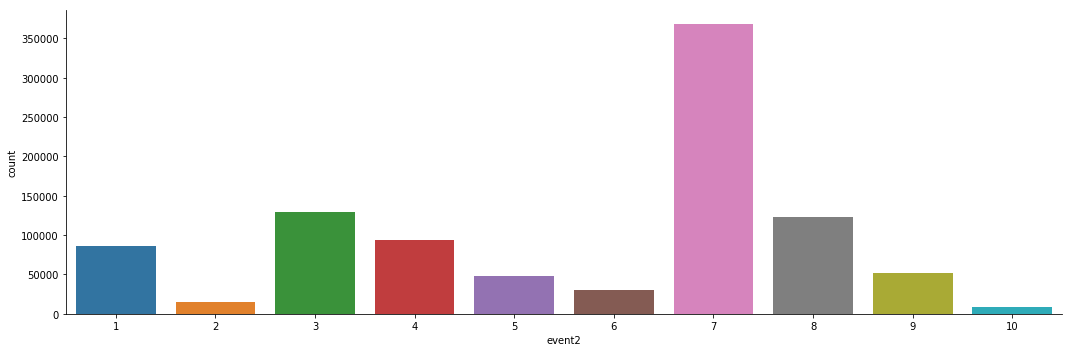

In [819]:
plt.figure(figsize=(15,4))
temp = online.groupby(['event2']).size().to_frame().reset_index().rename(columns={0:'count'})
#temp
sns.catplot(data=temp, x='event2', y='count', kind='bar', aspect=3)

### Distribution of online events - by product category + event2:  
- only have data for product category 1,2, and 3.
- most of the events happened on category 3 and event type 7 is still the most

In [563]:
online.category.unique()

array([3, 2, 1])

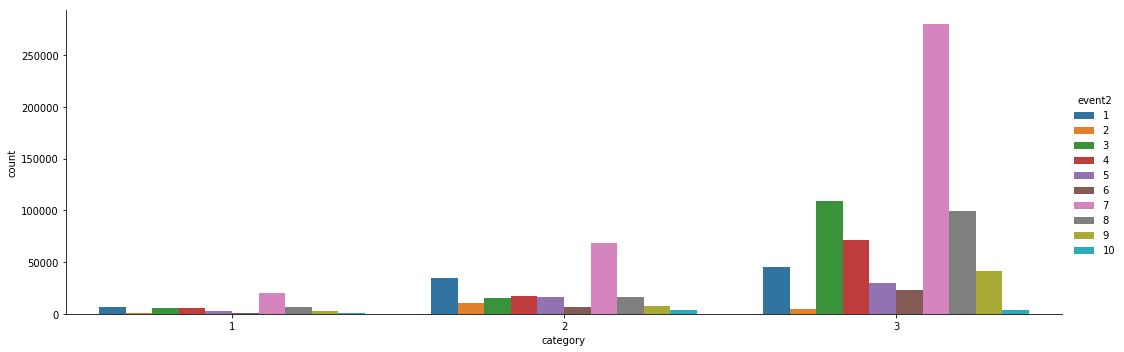

In [820]:
temp = online.groupby(['category','event2']).size().to_frame().reset_index().rename(columns={0:'count'})
#temp
sns.catplot(data=temp, x='category', y='count', hue='event2', kind='bar', aspect=3)

### Checking individual cases to get a sense how order data and online data linked together

##### Cust 9753

In [40]:
order[order.custno == 9753].sort_values(by=['orderdate'])

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
1823,9753,13520,2016-05-21 18:02:13,256.0,3,55.65
10856,9753,13520,2016-05-21 18:02:13,3.0,2,132.97
49525,9753,13520,2016-05-21 18:02:13,4.0,2,80.10


In [34]:
online[online.custno == 9753].sort_values(by=['dt'])

,session,visitor,dt,custno,category,event1,event2
157844,2087098,263238,2016-02-09 14:02:19,9753,2,NaN,8
66088,2087098,263238,2016-02-09 14:35:27,9753,2,NaN,3
658020,532674,467523,2016-04-03 15:31:11,9753,3,NaN,8
120296,2935608,278815,2016-05-15 11:18:34,9753,2,NaN,7
658018,804159,467523,2016-05-21 04:01:03,9753,3,NaN,8
750535,3153928,467523,2016-05-21 18:02:16,9753,3,NaN,9
43342,27886,278815,2016-08-24 18:34:35,9753,2,NaN,1
658019,2397139,467523,2016-11-15 07:04:02,9753,3,NaN,8


##### Cust 4

In [395]:
order[order.custno == 4].sort_values(by=['orderdate'])

,custno,ordno,orderdate,prodcat2,prodcat1,revenue,year,month,year_month
33,4,67324,2017-06-29 21:20:08,NaN,1,16.09,2017,6,2017-06
34,4,115090,2017-06-30 14:01:15,NaN,1,0.58,2017,6,2017-06
31,4,69265,2017-07-01 21:05:43,NaN,1,45.50,2017,7,2017-07
30,4,42271,2017-07-26 21:30:54,NaN,1,136.47,2017,7,2017-07
32,4,4,2017-08-14 21:22:10,NaN,1,33.92,2017,8,2017-08
29,4,41424,2017-09-05 00:51:03,NaN,1,38.31,2017,9,2017-09
35,4,96179,2017-09-07 18:29:30,NaN,1,76.68,2017,9,2017-09


In [396]:
online[online.custno == 4].sort_values(by=['dt'])

,session,visitor,dt,custno,category,event1,event2,year,month,year_month


How come this customer has order record but no online data?

##### Cust 77

In [402]:
order[(order.custno == 77) & (order.year ==2017)].sort_values(by=['orderdate'])

,custno,ordno,orderdate,prodcat2,prodcat1,revenue,year,month,year_month
101968,77,78,2017-05-26 13:31:10,11.0,1,137.30,2017,5,2017-05
111655,77,78,2017-05-26 13:31:10,12.0,1,53.11,2017,5,2017-05
222638,77,78,2017-05-26 13:31:10,89.0,1,103.35,2017,5,2017-05


In [401]:
online[online.custno == 77].sort_values(by=['dt'])

,session,visitor,dt,custno,category,event1,event2,year,month,year_month
4441,705280,242206,2017-05-08 15:15:17,77,1,NaN,2,2017,5,2017-05
252636,3432123,222299,2017-05-26 13:28:24,77,3,NaN,3,2017,5,2017-05


##### Cust 111

In [806]:
#order_T[(order_T.custno == 111) & (order_T.year ==2017)].sort_values(by=['orderdate'])

In [805]:
#order[(order.custno == 111) & (order.year ==2017)].sort_values(by=['orderdate'])

In [804]:
#online[online.custno == 111].sort_values(by=['dt'])

This customer has tons of orders but very few online records...and it only have online records about product 2, but it has purchased quite variety of the product categories... 

##### Case 7720

In [39]:
order[order.custno == 7720].sort_values(by=['orderdate'])

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
13472,7720,96697,2016-01-23 16:10:34,3.0,2,3.78
50464,7720,96697,2016-01-23 16:10:34,4.0,2,31.66
1824,7720,123109,2016-01-24 09:04:12,256.0,3,126.07
13471,7720,123109,2016-01-24 09:04:12,3.0,2,81.95
13473,7720,100517,2016-07-10 13:26:40,3.0,2,37.22
13469,7720,64040,2016-07-19 19:00:46,3.0,2,15.16
220643,7720,11500,2016-11-13 11:41:45,89.0,1,43.88
99856,7720,11500,2016-11-13 11:41:45,11.0,1,88.42
196940,7720,67299,2016-12-15 15:19:37,58.0,4,79.79
145619,7720,67299,2016-12-15 15:19:37,18.0,4,110.59


In [35]:
online[online.custno == 7720].sort_values(by=['dt'])

,session,visitor,dt,custno,category,event1,event2
122667,719643,462767,2016-01-28 18:27:45,7720,2,NaN,7
158827,719643,462767,2016-01-28 18:28:46,7720,2,NaN,8
480223,3719403,106745,2016-07-10 12:55:10,7720,3,NaN,7
339145,3719403,106745,2016-07-10 13:22:29,7720,3,NaN,4
664111,3176885,106745,2016-07-19 18:41:10,7720,3,NaN,8
402248,2654228,106745,2016-09-11 13:39:51,7720,3,NaN,5
850099,1178759,398839,2016-10-23 15:01:36,7720,3,2.0,7
66964,2239592,109521,2016-11-11 06:39:43,7720,2,NaN,3
82201,2239592,109521,2016-11-11 06:40:07,7720,2,NaN,4
480221,1769799,34127,2016-12-15 06:48:20,7720,3,NaN,7


Seems like Customers can bypass online records and order product directly...

## 1.4 Customer Segmentation <a id='CustSeg'></a>

Running out of time to try out this part, so provide my thoughts here: a common way is to use RFM segmentation, but there're some other characteristics that I'd be interested about, and it'd also be good to have an application idea in mind to better decide the segmentation variables.
- New or repeat customer (whether purchased any product before current order?)
- Diverse puchaser or mono (whether puchased multiple prodcat before?)
- Think more before purchase (does the customer has lots of online visit records before each order?)
- length of tenure (how long have they been our customer?)
- big or small size purchaser (how many item purchased per order?)

## 2 Feature engineering	<a id='F-eng'></a>

Behavioral variables - product category & event type:
- R/F/M within 1/3/6/9/12 months
- Ever order or visit within 1/3/6/9/12 months
- Days/orders/visits since last orders

### Purchase behavior

In [209]:
order = order.sort_values(by=['custno','orderdate']).reset_index().drop(columns='index')
order['orderdate'] = order.orderdate.astype(np.datetime64)
order.head()

,custno,ordno,orderdate,prodcat2,prodcat1,revenue,year,month,year_month
0,1,1,2017-06-12 08:27:59,NaN,1,8.35,2017,6,2017-06
1,2,70848,2016-01-26 14:14:21,NaN,1,23.84,2016,1,2016-01
2,2,112461,2016-01-26 14:23:21,NaN,1,94.50,2016,1,2016-01
3,2,2,2016-03-29 13:04:27,NaN,1,13.58,2016,3,2016-03
4,2,15645,2016-08-29 10:50:33,NaN,1,149.92,2016,8,2016-08


##### order base

In [210]:
order_base = order.groupby(['custno','ordno','orderdate','year','month','year_month']).revenue.agg(['count','sum'])\
                .rename(columns={'count':'item_cnt','sum':'revenue'}).sort_values(by=['custno','orderdate']).reset_index()
print(order_base.shape)
order_base.head()

(149717, 8)


,custno,ordno,orderdate,year,month,year_month,item_cnt,revenue
0,1,1,2017-06-12 08:27:59,2017,6,2017-06,1,8.35
1,2,70848,2016-01-26 14:14:21,2016,1,2016-01,1,23.84
2,2,112461,2016-01-26 14:23:21,2016,1,2016-01,1,94.50
3,2,2,2016-03-29 13:04:27,2016,3,2016-03,1,13.58
4,2,15645,2016-08-29 10:50:33,2016,8,2016-08,1,149.92


In [212]:
# first order date
order_base['first_orderdate'] = order_base.groupby(['custno']).orderdate.transform('min')
order_base['first_order_flag'] = (order_base['orderdate'] == order_base['first_orderdate'])*1

# last order date
order_base['last_orderdate'] = order_base.groupby('custno').orderdate.transform('shift')

# days since last order - by prodcat
order_base['days_since_last_order'] = order_base['orderdate'] - order_base['last_orderdate']
order_base['days_since_last_order'] = order_base['days_since_last_order'].dt.days

#order_base.head(5)

transform

In [213]:
order_agg = order.groupby(['ordno','prodcat1']).revenue.agg(['count','sum']).reset_index()
#order_agg.head()

prodcat_flag

In [214]:
prodcat_flag = pd.get_dummies(order_agg[['ordno','prodcat1']],columns=['prodcat1']).groupby(['ordno']).max().reset_index()
print(prodcat_flag.shape)
prodcat_flag.head(3)

(149717, 7)


,ordno,prodcat1_1,prodcat1_2,prodcat1_3,prodcat1_4,prodcat1_5,prodcat1_7
0,1,1,0,0,0,0,0
1,2,1,0,0,0,0,0
2,3,1,0,0,0,0,0


In [215]:
order_base = order_base.merge(prodcat_flag, on='ordno', how='left')
#order_base.head()

prodcat_cnt

In [216]:
prodcat_cnt = order_agg.pivot(index='ordno', columns='prodcat1')['count'].reset_index().fillna(0).\
             rename(columns={1:'prodcat_1_cnt',2:'prodcat_2_cnt',3:'prodcat_3_cnt',4:'prodcat_4_cnt',5:'prodcat_5_cnt',7:'prodcat_7_cnt'})
prodcat_cnt.head(3)

prodcat1,ordno,prodcat_1_cnt,prodcat_2_cnt,prodcat_3_cnt,prodcat_4_cnt,prodcat_5_cnt,prodcat_7_cnt
0,1,1.0,0.0,0.0,0.0,0.0,0.0
1,2,1.0,0.0,0.0,0.0,0.0,0.0
2,3,1.0,0.0,0.0,0.0,0.0,0.0


In [217]:
order_base = order_base.merge(prodcat_cnt, on='ordno', how='left')
#order_base.head()

prodcat_revenue

In [218]:
prodcat_rev = order_agg.pivot(index='ordno', columns='prodcat1')['sum'].reset_index().fillna(0).\
             rename(columns={1:'prodcat_1_rev',2:'prodcat_2_rev',3:'prodcat_3_rev',4:'prodcat_4_rev',5:'prodcat_5_rev',7:'prodcat_7_rev'})
prodcat_rev.head(3)

prodcat1,ordno,prodcat_1_rev,prodcat_2_rev,prodcat_3_rev,prodcat_4_rev,prodcat_5_rev,prodcat_7_rev
0,1,8.35,0.0,0.0,0.0,0.0,0.0
1,2,13.58,0.0,0.0,0.0,0.0,0.0
2,3,95.76,0.0,0.0,0.0,0.0,0.0


In [219]:
order_base = order_base.merge(prodcat_rev, on='ordno', how='left')
#order_base.head()

cumulative cnt & revenue - by prodcat

In [220]:
# ever
for i in [1,2,3,4,5,7]:
    in_col_name = 'prodcat1_' + str(i)
    out_col_name = 'prodcat_' + str(i) + '_ever' 
    order_base[out_col_name] = (order_base.groupby('custno')[in_col_name].cumsum() > 0)*1

# cnt
for i in [1,2,3,4,5,7]:
    in_col_name = 'prodcat_' + str(i) + '_cnt'
    out_col_name = 'prodcat_' + str(i) + '_cnt' + '_cum'
    order_base[out_col_name] = order_base.groupby('custno')[in_col_name].cumsum()
    
# revenue
for i in [1,2,3,4,5,7]:
    in_col_name = 'prodcat_' + str(i) + '_rev'
    out_col_name = 'prodcat_' + str(i) + '_rev' + '_cum'
    order_base[out_col_name] = order_base.groupby('custno')[in_col_name].cumsum()

order behavior within 1/3/6/12 M 

In [221]:
col = ['custno','orderdate']

for i in order_base.columns:
    if 'prodcat_' in i and 'cum' not in i and 'ever' not in i:
        col.append(i)       
#col

In [279]:
order_self_joined = order_base[['custno','ordno','orderdate','last_orderdate']].merge(order_base[col], on='custno', how='left')
# only select records before current order
order_self_joined = order_self_joined[order_self_joined.orderdate_x > order_self_joined.orderdate_y]

In [223]:
#order_self_joined[order_self_joined.custno==2]

Purchased item counts and revenue within 1/3/6/9/12 months prior to current order - by prodcat1

In [224]:
for j in [1,3,6,9,12]:
    
    temp = order_self_joined[order_self_joined.orderdate_y >= order_self_joined.orderdate_x - np.timedelta64(j,'M')]
    temp_groupby = temp.groupby('ordno').sum().reset_index().drop(columns='custno')
    
    # ever
    for i in [1,2,3,4,5,7]:
        in_col_name = 'prodcat_' + str(i) + '_cnt'
        out_col_name = 'prodcat_' + str(i) + '_ever'
        temp_groupby[out_col_name] = (temp_groupby[in_col_name] > 0)*1
    
    # note time frame
    new_col_name = ['ordno']

    for i in temp_groupby.columns:
        if i != 'ordno':
            i_new = i + '_' + str(j) + 'm'
            new_col_name.append(i_new)

    temp_groupby.columns = new_col_name
    
    #print(temp_groupby.columns)
    
    order_base = order_base.merge(temp_groupby, on='ordno', how='left')
    

In [811]:
#order_base.columns[-90:]

In [226]:
order_base.head()

,custno,ordno,orderdate,year,month,year_month,item_cnt,revenue,first_orderdate,first_order_flag,last_orderdate,days_since_last_order,prodcat1_1,prodcat1_2,prodcat1_3,prodcat1_4,prodcat1_5,prodcat1_7,prodcat_1_cnt,prodcat_2_cnt,prodcat_3_cnt,prodcat_4_cnt,prodcat_5_cnt,prodcat_7_cnt,prodcat_1_rev,prodcat_2_rev,prodcat_3_rev,prodcat_4_rev,prodcat_5_rev,prodcat_7_rev,prodcat_1_ever,prodcat_2_ever,prodcat_3_ever,prodcat_4_ever,prodcat_5_ever,prodcat_7_ever,prodcat_1_cnt_cum,prodcat_2_cnt_cum,prodcat_3_cnt_cum,prodcat_4_cnt_cum,prodcat_5_cnt_cum,prodcat_7_cnt_cum,prodcat_1_rev_cum,prodcat_2_rev_cum,prodcat_3_rev_cum,prodcat_4_rev_cum,prodcat_5_rev_cum,prodcat_7_rev_cum,prodcat_1_cnt_1m,prodcat_2_cnt_1m,prodcat_3_cnt_1m,prodcat_4_cnt_1m,prodcat_5_cnt_1m,prodcat_7_cnt_1m,prodcat_1_rev_1m,prodcat_2_rev_1m,prodcat_3_rev_1m,prodcat_4_rev_1m,prodcat_5_rev_1m,prodcat_7_rev_1m,prodcat_1_ever_1m,prodcat_2_ever_1m,prodcat_3_ever_1m,prodcat_4_ever_1m,prodcat_5_ever_1m,prodcat_7_ever_1m,prodcat_1_cnt_3m,prodcat_2_cnt_3m,prodcat_3_cnt_3m,prodcat_4_cnt_3m,prodcat_5_cnt_3m,prodcat_7_cnt_3m,prodcat_1_rev_3m,prodcat_2_rev_3m,prodcat_3_rev_3m,prodcat_4_rev_3m,prodcat_5_rev_3m,prodcat_7_rev_3m,prodcat_1_ever_3m,prodcat_2_ever_3m,prodcat_3_ever_3m,prodcat_4_ever_3m,prodcat_5_ever_3m,prodcat_7_ever_3m,prodcat_1_cnt_6m,prodcat_2_cnt_6m,prodcat_3_cnt_6m,prodcat_4_cnt_6m,prodcat_5_cnt_6m,prodcat_7_cnt_6m,prodcat_1_rev_6m,prodcat_2_rev_6m,prodcat_3_rev_6m,prodcat_4_rev_6m,prodcat_5_rev_6m,prodcat_7_rev_6m,prodcat_1_ever_6m,prodcat_2_ever_6m,prodcat_3_ever_6m,prodcat_4_ever_6m,prodcat_5_ever_6m,prodcat_7_ever_6m,prodcat_1_cnt_9m,prodcat_2_cnt_9m,prodcat_3_cnt_9m,prodcat_4_cnt_9m,prodcat_5_cnt_9m,prodcat_7_cnt_9m,prodcat_1_rev_9m,prodcat_2_rev_9m,prodcat_3_rev_9m,prodcat_4_rev_9m,prodcat_5_rev_9m,prodcat_7_rev_9m,prodcat_1_ever_9m,prodcat_2_ever_9m,prodcat_3_ever_9m,prodcat_4_ever_9m,prodcat_5_ever_9m,prodcat_7_ever_9m,prodcat_1_cnt_12m,prodcat_2_cnt_12m,prodcat_3_cnt_12m,prodcat_4_cnt_12m,prodcat_5_cnt_12m,prodcat_7_cnt_12m,prodcat_1_rev_12m,prodcat_2_rev_12m,prodcat_3_rev_12m,prodcat_4_rev_12m,prodcat_5_rev_12m,prodcat_7_rev_12m,prodcat_1_ever_12m,prodcat_2_ever_12m,prodcat_3_ever_12m,prodcat_4_ever_12m,prodcat_5_ever_12m,prodcat_7_ever_12m
0,1,1,2017-06-12 08:27:59,2017,6,2017-06,1,8.35,2017-06-12 08:27:59,1,NaT,NaN,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,8.35,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,8.35,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,70848,2016-01-26 14:14:21,2016,1,2016-01,1,23.84,2016-01-26 14:14:21,1,NaT,NaN,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,23.84,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,23.84,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,112461,2016-01-26 14:23:21,2016,1,2016-01,1,94.50,2016-01-26 14:14:21,0,2016-01-26 14:14:21,0.0,1,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,94.50,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,2.0,0.0,0.0,0.0,0.0,0.0,118.34,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23.84,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23.84,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23.84,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23.84,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,23.84,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2,2,2016-03-29 13:04:27,2

Days since last order - by prodcat

In [808]:
#order_self_joined

In [288]:
prodcat1 = order.prodcat1.unique()
prodcat1.sort()
prodcat1

array([1, 2, 3, 4, 5, 7])

In [293]:
for i in prodcat1:
    in_col_name = 'prodcat_' + str(i) +'_cnt'
    out_col_name = 'last_orderdate_prodcat_' + str(i)
    
    temp = order_self_joined[order_self_joined[in_col_name] > 0].groupby(['ordno']).orderdate_y.max().\
            reset_index().rename(columns={'orderdate_y':out_col_name})
    
    order_base = order_base.merge(temp, on='ordno', how='left')

In [296]:
for i in prodcat1:
    
    in_col_name = 'last_orderdate_prodcat_' + str(i)
    out_col_name = 'days_since_last_order_prodcat_' + str(i)
    
    order_base[out_col_name] = order_base['orderdate'] - order_base[in_col_name]
    order_base[out_col_name] = order_base[out_col_name].dt.days

In [807]:
#order_base[order_base.custno==2]

In [344]:
order_base['prodcat_cnt'] = order_base['prodcat1_1'] + order_base['prodcat1_2'] \
                            + order_base['prodcat1_3'] + order_base['prodcat1_4'] \
                            + order_base['prodcat1_5'] + order_base['prodcat1_7']

In [298]:
order_base_2017 = order_base[order_base.year==2017]
order_base_2017.shape

(52642, 150)

### online behavior

In [174]:
online = online.sort_values(by=['custno','dt']).reset_index().drop(columns={'index'})

In [175]:
print(online.shape)
online.head()

(954774, 10)


,session,visitor,dt,custno,category,event1,event2,year,month,year_month
0,1445475,20633,2016-01-03 12:22:57,6,3,NaN,4,2016,1,2016-01
1,3685850,309731,2016-10-06 20:32:22,6,3,NaN,3,2016,10,2016-10
2,2391077,309731,2016-11-01 20:00:28,6,3,NaN,7,2016,11,2016-11
3,3040697,310976,2016-11-16 10:38:02,6,2,NaN,7,2016,11,2016-11
4,3624597,290914,2017-05-15 20:23:14,6,3,NaN,7,2017,5,2017-05


In [176]:
online.dt.min()

Timestamp('2016-01-01 00:00:08')

In [177]:
online.dt.max()

Timestamp('2017-12-31 23:58:05')

###### Check missing values:
remove event1 due to 83% missing values.

In [178]:
online.isna().sum() / online.shape[0]

session       0.00000
visitor       0.00000
dt            0.00000
custno        0.00000
category      0.00000
event1        0.82726
event2        0.00000
year          0.00000
month         0.00000
year_month    0.00000
dtype: float64

Create base table

In [179]:
order_base_2017[['custno','ordno','orderdate']].shape

(52642, 3)

In [269]:
event_base = order_base_2017[['custno','ordno','orderdate','last_orderdate']].copy()
event_base = event_base.merge(online, how='left',on='custno').drop(columns={'event1','session','visitor','year','month','year_month'})

In [270]:
event_base = event_base[event_base.orderdate > event_base.dt]

In [271]:
print(event_base.shape)
event_base.head()

(1172712, 7)


,custno,ordno,orderdate,last_orderdate,dt,category,event2
15,8,6764,2017-03-12 16:52:24,2016-12-13 17:53:21,2016-05-13 14:26:36,3.0,4.0
16,8,6764,2017-03-12 16:52:24,2016-12-13 17:53:21,2016-05-17 08:58:42,3.0,8.0
17,8,6764,2017-03-12 16:52:24,2016-12-13 17:53:21,2016-06-02 15:31:58,3.0,8.0
18,8,6764,2017-03-12 16:52:24,2016-12-13 17:53:21,2016-06-17 07:46:33,3.0,7.0
19,8,6764,2017-03-12 16:52:24,2016-12-13 17:53:21,2016-06-17 09:14:02,3.0,4.0


In [193]:
event_base.isna().sum()

custno       0
ordno        0
orderdate    0
dt           0
category     0
event2       0
dtype: int64

In [272]:
event_base.dtypes

custno                     int64
ordno                      int64
orderdate         datetime64[ns]
last_orderdate    datetime64[ns]
dt                datetime64[ns]
category                 float64
event2                   float64
dtype: object

Total numbers of event2

In [199]:
event_agg = event_base.groupby('ordno').agg({'event2':'count'}).reset_index().\
            rename(columns={'event2':'event2_cnt_cum'})

I have decided to use orders in 2017 as my model base. Reasoning explained in Model Design & Sampling section

In [299]:
order_base_2017 = order_base_2017.merge(event_agg, on='ordno', how='left')
order_base_2017.tail(5)

,custno,ordno,orderdate,year,month,year_month,item_cnt,revenue,first_orderdate,first_order_flag,last_orderdate,days_since_last_order,prodcat1_1,prodcat1_2,prodcat1_3,prodcat1_4,prodcat1_5,prodcat1_7,prodcat_1_cnt,prodcat_2_cnt,prodcat_3_cnt,prodcat_4_cnt,prodcat_5_cnt,prodcat_7_cnt,prodcat_1_rev,prodcat_2_rev,prodcat_3_rev,prodcat_4_rev,prodcat_5_rev,prodcat_7_rev,prodcat_1_ever,prodcat_2_ever,prodcat_3_ever,prodcat_4_ever,prodcat_5_ever,prodcat_7_ever,prodcat_1_cnt_cum,prodcat_2_cnt_cum,prodcat_3_cnt_cum,prodcat_4_cnt_cum,prodcat_5_cnt_cum,prodcat_7_cnt_cum,prodcat_1_rev_cum,prodcat_2_rev_cum,prodcat_3_rev_cum,prodcat_4_rev_cum,prodcat_5_rev_cum,prodcat_7_rev_cum,prodcat_1_cnt_1m,prodcat_2_cnt_1m,prodcat_3_cnt_1m,prodcat_4_cnt_1m,prodcat_5_cnt_1m,prodcat_7_cnt_1m,prodcat_1_rev_1m,prodcat_2_rev_1m,prodcat_3_rev_1m,prodcat_4_rev_1m,prodcat_5_rev_1m,prodcat_7_rev_1m,prodcat_1_ever_1m,prodcat_2_ever_1m,prodcat_3_ever_1m,prodcat_4_ever_1m,prodcat_5_ever_1m,prodcat_7_ever_1m,prodcat_1_cnt_3m,prodcat_2_cnt_3m,prodcat_3_cnt_3m,prodcat_4_cnt_3m,prodcat_5_cnt_3m,prodcat_7_cnt_3m,prodcat_1_rev_3m,prodcat_2_rev_3m,prodcat_3_rev_3m,prodcat_4_rev_3m,prodcat_5_rev_3m,prodcat_7_rev_3m,prodcat_1_ever_3m,prodcat_2_ever_3m,prodcat_3_ever_3m,prodcat_4_ever_3m,prodcat_5_ever_3m,prodcat_7_ever_3m,prodcat_1_cnt_6m,prodcat_2_cnt_6m,prodcat_3_cnt_6m,prodcat_4_cnt_6m,prodcat_5_cnt_6m,prodcat_7_cnt_6m,prodcat_1_rev_6m,prodcat_2_rev_6m,prodcat_3_rev_6m,prodcat_4_rev_6m,prodcat_5_rev_6m,prodcat_7_rev_6m,prodcat_1_ever_6m,prodcat_2_ever_6m,prodcat_3_ever_6m,prodcat_4_ever_6m,prodcat_5_ever_6m,prodcat_7_ever_6m,prodcat_1_cnt_9m,prodcat_2_cnt_9m,prodcat_3_cnt_9m,prodcat_4_cnt_9m,prodcat_5_cnt_9m,prodcat_7_cnt_9m,prodcat_1_rev_9m,prodcat_2_rev_9m,prodcat_3_rev_9m,prodcat_4_rev_9m,prodcat_5_rev_9m,prodcat_7_rev_9m,prodcat_1_ever_9m,prodcat_2_ever_9m,prodcat_3_ever_9m,prodcat_4_ever_9m,prodcat_5_ever_9m,prodcat_7_ever_9m,prodcat_1_cnt_12m,prodcat_2_cnt_12m,prodcat_3_cnt_12m,prodcat_4_cnt_12m,prodcat_5_cnt_12m,prodcat_7_cnt_12m,prodcat_1_rev_12m,prodcat_2_rev_12m,prodcat_3_rev_12m,prodcat_4_rev_12m,prodcat_5_rev_12m,prodcat_7_rev_12m,prodcat_1_ever_12m,prodcat_2_ever_12m,prodcat_3_ever_12m,prodcat_4_ever_12m,prodcat_5_ever_12m,prodcat_7_ever_12m,last_orderdate_prodcat_1,last_orderdate_prodcat_2,last_orderdate_prodcat_3,last_orderdate_prodcat_4,last_orderdate_prodcat_5,last_orderdate_prodcat_7,days_since_last_order_prodcat_1,days_since_last_order_prodcat_2,days_since_last_order_prodcat_3,days_since_last_order_prodcat_4,days_since_last_order_prodcat_5,days_since_last_order_prodcat_7,event2_cnt_cum
52637,71407,154364,2017-04-12 19:22:07,2017,4,2017-04,1,8.18,2017-04-12 19:22:07,1,NaT,NaN,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,0.00,8.18,0.0,0.0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,0.00,8.18,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1.0
52638,71410,154373,2017-01-04 07:11:34,2017,1,2017-01,1,62.13,2017-01-04 07:11:34,1,NaT,NaN,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.00,62.13,0.00,0.0,0.0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.00,62.13,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52639,71412,154377,2017-08-15 16:28:11,2017,8,2017-08,1,70.22,2017-08-15 16:28:11,1,NaT,NaN,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0

Total numbers of event2 - by prodcat1

In [249]:
category = event_base.category.unique()
category.sort()
category

array([1., 2., 3.])

In [300]:
for i in [1,3,6,9,12]:  # months
    for j in category:
        temp = event_base[(event_base.dt >= event_base.orderdate - np.timedelta64(i,'M')) & (event_base.category==j)]
        temp_groupby = temp.groupby('ordno').agg({'event2':'count'}).reset_index().\
                    rename(columns={'event2':'event2_prodcat_'+str(int(j))+'_cnt_'+str(i)+'m'})
        order_base_2017 = order_base_2017.merge(temp_groupby, on='ordno', how='left')

In [301]:
order_base_2017.columns[-15:]

Index(['event2_prodcat_1_cnt_1m', 'event2_prodcat_2_cnt_1m',
       'event2_prodcat_3_cnt_1m', 'event2_prodcat_1_cnt_3m',
       'event2_prodcat_2_cnt_3m', 'event2_prodcat_3_cnt_3m',
       'event2_prodcat_1_cnt_6m', 'event2_prodcat_2_cnt_6m',
       'event2_prodcat_3_cnt_6m', 'event2_prodcat_1_cnt_9m',
       'event2_prodcat_2_cnt_9m', 'event2_prodcat_3_cnt_9m',
       'event2_prodcat_1_cnt_12m', 'event2_prodcat_2_cnt_12m',
       'event2_prodcat_3_cnt_12m'],
      dtype='object')

In [302]:
order_base_2017.tail(5)

,custno,ordno,orderdate,year,month,year_month,item_cnt,revenue,first_orderdate,first_order_flag,last_orderdate,days_since_last_order,prodcat1_1,prodcat1_2,prodcat1_3,prodcat1_4,prodcat1_5,prodcat1_7,prodcat_1_cnt,prodcat_2_cnt,prodcat_3_cnt,prodcat_4_cnt,prodcat_5_cnt,prodcat_7_cnt,prodcat_1_rev,prodcat_2_rev,prodcat_3_rev,prodcat_4_rev,prodcat_5_rev,prodcat_7_rev,prodcat_1_ever,prodcat_2_ever,prodcat_3_ever,prodcat_4_ever,prodcat_5_ever,prodcat_7_ever,prodcat_1_cnt_cum,prodcat_2_cnt_cum,prodcat_3_cnt_cum,prodcat_4_cnt_cum,prodcat_5_cnt_cum,prodcat_7_cnt_cum,prodcat_1_rev_cum,prodcat_2_rev_cum,prodcat_3_rev_cum,prodcat_4_rev_cum,prodcat_5_rev_cum,prodcat_7_rev_cum,prodcat_1_cnt_1m,prodcat_2_cnt_1m,prodcat_3_cnt_1m,prodcat_4_cnt_1m,prodcat_5_cnt_1m,prodcat_7_cnt_1m,prodcat_1_rev_1m,prodcat_2_rev_1m,prodcat_3_rev_1m,prodcat_4_rev_1m,prodcat_5_rev_1m,prodcat_7_rev_1m,prodcat_1_ever_1m,prodcat_2_ever_1m,prodcat_3_ever_1m,prodcat_4_ever_1m,prodcat_5_ever_1m,prodcat_7_ever_1m,prodcat_1_cnt_3m,prodcat_2_cnt_3m,prodcat_3_cnt_3m,prodcat_4_cnt_3m,prodcat_5_cnt_3m,prodcat_7_cnt_3m,prodcat_1_rev_3m,prodcat_2_rev_3m,prodcat_3_rev_3m,prodcat_4_rev_3m,prodcat_5_rev_3m,prodcat_7_rev_3m,prodcat_1_ever_3m,prodcat_2_ever_3m,prodcat_3_ever_3m,prodcat_4_ever_3m,prodcat_5_ever_3m,prodcat_7_ever_3m,prodcat_1_cnt_6m,prodcat_2_cnt_6m,prodcat_3_cnt_6m,prodcat_4_cnt_6m,prodcat_5_cnt_6m,prodcat_7_cnt_6m,prodcat_1_rev_6m,prodcat_2_rev_6m,prodcat_3_rev_6m,prodcat_4_rev_6m,prodcat_5_rev_6m,prodcat_7_rev_6m,prodcat_1_ever_6m,prodcat_2_ever_6m,prodcat_3_ever_6m,prodcat_4_ever_6m,prodcat_5_ever_6m,prodcat_7_ever_6m,prodcat_1_cnt_9m,prodcat_2_cnt_9m,prodcat_3_cnt_9m,prodcat_4_cnt_9m,prodcat_5_cnt_9m,prodcat_7_cnt_9m,prodcat_1_rev_9m,prodcat_2_rev_9m,prodcat_3_rev_9m,prodcat_4_rev_9m,prodcat_5_rev_9m,prodcat_7_rev_9m,prodcat_1_ever_9m,prodcat_2_ever_9m,prodcat_3_ever_9m,prodcat_4_ever_9m,prodcat_5_ever_9m,prodcat_7_ever_9m,prodcat_1_cnt_12m,prodcat_2_cnt_12m,prodcat_3_cnt_12m,prodcat_4_cnt_12m,prodcat_5_cnt_12m,prodcat_7_cnt_12m,prodcat_1_rev_12m,prodcat_2_rev_12m,prodcat_3_rev_12m,prodcat_4_rev_12m,prodcat_5_rev_12m,prodcat_7_rev_12m,prodcat_1_ever_12m,prodcat_2_ever_12m,prodcat_3_ever_12m,prodcat_4_ever_12m,prodcat_5_ever_12m,prodcat_7_ever_12m,last_orderdate_prodcat_1,last_orderdate_prodcat_2,last_orderdate_prodcat_3,last_orderdate_prodcat_4,last_orderdate_prodcat_5,last_orderdate_prodcat_7,days_since_last_order_prodcat_1,days_since_last_order_prodcat_2,days_since_last_order_prodcat_3,days_since_last_order_prodcat_4,days_since_last_order_prodcat_5,days_since_last_order_prodcat_7,event2_cnt_cum,event2_prodcat_1_cnt_1m,event2_prodcat_2_cnt_1m,event2_prodcat_3_cnt_1m,event2_prodcat_1_cnt_3m,event2_prodcat_2_cnt_3m,event2_prodcat_3_cnt_3m,event2_prodcat_1_cnt_6m,event2_prodcat_2_cnt_6m,event2_prodcat_3_cnt_6m,event2_prodcat_1_cnt_9m,event2_prodcat_2_cnt_9m,event2_prodcat_3_cnt_9m,event2_prodcat_1_cnt_12m,event2_prodcat_2_cnt_12m,event2_prodcat_3_cnt_12m
52637,71407,154364,2017-04-12 19:22:07,2017,4,2017-04,1,8.18,2017-04-12 19:22:07,1,NaT,NaN,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,0.00,8.18,0.0,0.0,0,0,0,1,0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.00,0.00,0.00,8.18,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0
52638,71410,154373,2017-01-04 07:11:34,2017,1,2017-01,1,62.13,2017-01-04 07:11:34,1,NaT,NaN,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.00,62.13,0.00,0.0,0.0,0,0,1,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,0.00,0.00,62.13,0.00,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

Numbers of event2 - by types + prodcat

In [304]:
event2_type = event_base.event2.unique()
event2_type.sort()
event2_type

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [305]:
for i in [1,3,6,9,12]:  # months
    for j in category:
        for k in event2_type:
            temp = event_base[(event_base.dt >= event_base.orderdate - np.timedelta64(i,'M')) & (event_base.category==j) & (event_base.event2==k)]
            temp_groupby = temp.groupby('ordno').agg({'event2':'count'}).reset_index().\
                        rename(columns={'event2':'event2_'+str(int(k))+'_prodcat_'+str(int(j))+'_cnt_'+str(i)+'m'})
            order_base_2017 = order_base_2017.merge(temp_groupby, on='ordno', how='left')

In [306]:
order_base_2017.columns[-150:]

Index(['event2_1_prodcat_1_cnt_1m', 'event2_2_prodcat_1_cnt_1m',
       'event2_3_prodcat_1_cnt_1m', 'event2_4_prodcat_1_cnt_1m',
       'event2_5_prodcat_1_cnt_1m', 'event2_6_prodcat_1_cnt_1m',
       'event2_7_prodcat_1_cnt_1m', 'event2_8_prodcat_1_cnt_1m',
       'event2_9_prodcat_1_cnt_1m', 'event2_10_prodcat_1_cnt_1m',
       ...
       'event2_1_prodcat_3_cnt_12m', 'event2_2_prodcat_3_cnt_12m',
       'event2_3_prodcat_3_cnt_12m', 'event2_4_prodcat_3_cnt_12m',
       'event2_5_prodcat_3_cnt_12m', 'event2_6_prodcat_3_cnt_12m',
       'event2_7_prodcat_3_cnt_12m', 'event2_8_prodcat_3_cnt_12m',
       'event2_9_prodcat_3_cnt_12m', 'event2_10_prodcat_3_cnt_12m'],
      dtype='object', length=150)

Numbers of event2 since last order - by prodcat

In [307]:
for j in category:
    temp = event_base[(event_base.dt >= event_base.last_orderdate) & (event_base.category==j)]
    temp_groupby = temp.groupby('ordno').agg({'event2':'count'}).reset_index().\
                    rename(columns={'event2':'event2_prodcat_'+str(int(j))+'_cnt_since_last_order'})
    order_base_2017 = order_base_2017.merge(temp_groupby, on='ordno', how='left')

In [308]:
order_base_2017.columns[-3:]

Index(['event2_prodcat_1_cnt_since_last_order',
       'event2_prodcat_2_cnt_since_last_order',
       'event2_prodcat_3_cnt_since_last_order'],
      dtype='object')

In [821]:
#order_base_2017.isna().sum()

fill NA

In [803]:
#order_base_2017.head(3)

In [315]:
col = []

for i in order_base_2017.columns:
    if 'cnt' in i or 'rev' in i or 'ever' in i:
        col.append(i)
        order_base_2017[i].fillna(0, inplace=True)
        
#col

In [794]:
#order_base_2017.isna().sum().sort_values(ascending=False)

In [795]:
col = []

for i in order_base_2017.columns:
    if 'date' in i:
        col.append(i)
        order_base_2017.drop(columns=i, inplace=True)
        
#col

In [328]:
prodcat1 = order.prodcat1.unique()
prodcat1.sort()
prodcat1

array([1, 2, 3, 4, 5, 7])

In [802]:
#order_base_2017.head(3)

In [342]:
order_base_2017['prodcat_cnt'] = order_base_2017['prodcat1_1'] + order_base_2017['prodcat1_2'] \
                                + order_base_2017['prodcat1_3'] + order_base_2017['prodcat1_4'] \
                                + order_base_2017['prodcat1_5'] + order_base_2017['prodcat1_7']

In [351]:
order_base_2017['prodcat_cnt_cum_max'] = order_base_2017[['prodcat_1_cnt_cum','prodcat_2_cnt_cum',\
                                                          'prodcat_3_cnt_cum','prodcat_4_cnt_cum','prodcat_5_cnt_cum',\
                                                          'prodcat_7_cnt_cum']].max(axis=1)

In [352]:
order_base_2017['final_product'] = \
order_base_2017.apply(lambda d: d['prodcat1_1']*1 + d['prodcat1_2']*2 + d['prodcat1_3']*3 + d['prodcat1_4']*4 \
                      + d['prodcat1_5']*5 + d['prodcat1_7']*7 if d['prodcat_cnt']==1 \
                      else 1 if d['prodcat_1_cnt_cum']== d['prodcat_cnt_cum_max']  \
                      else 2 if d['prodcat_2_cnt_cum']== d['prodcat_cnt_cum_max']  \
                      else 3 if d['prodcat_3_cnt_cum']== d['prodcat_cnt_cum_max']  \
                      else 4 if d['prodcat_4_cnt_cum']== d['prodcat_cnt_cum_max']  \
                      else 5 if d['prodcat_5_cnt_cum']== d['prodcat_cnt_cum_max']  \
                      else 7 if d['prodcat_7_cnt_cum']== d['prodcat_cnt_cum_max']  \
                      else np.NaN
                      , axis=1)

Check missing value

In [353]:
order_base_2017['final_product'].isna().sum() / order_base_2017.shape[0]

0.0

## 3 Modeling	 <a id='Modeling'></a>

## 3.1 Design & Sampling <a id='M-design'></a>

#### Objective:
To train a model that predicts which product category a customer is more likely to purchase next, I used order and online behaviors that happened before current purchase to predict the product category the customer purchased at this time. 

#### Sampling Period:
- <u>Order Dataset</u>: data in year 2017, so that I have at least one year of observation period before current order.
- <u>Online Dataset</u>: data between year 2016 and 2017.

#### Outcome Variable:
- <u>Prodcat1</u>: 
    - over 80% of the orders contained only one category; for orders with multiple categories, I selected the category that customer purchased the most before.
    - another potential way to deal with multiple categories per order is to see it as another outcome, but now I just simply used above approach.

#### Predictor Variables: 
- <u>Customer Characteristics</u>: not included this time
- <u>Previous Purchase Behavior</u>: frequency, recency, monetary
- <u>Previous Visit Behavior</u>: frequency, recency 
- <u>External factor</u>: Month of purchase

#### Model Selection:
- Xgboost: generally have high performance; can take care of highly-correlated variables; can show feature importance to facilitate feature selection. 

In [407]:
len(order_base_2017.columns)

313

In [408]:
#order_base_2017.columns

Index(['custno', 'ordno', 'year', 'month', 'year_month', 'item_cnt', 'revenue',
       'first_order_flag', 'days_since_last_order', 'prodcat1_1',
       ...
       'event2_7_prodcat_3_cnt_12m', 'event2_8_prodcat_3_cnt_12m',
       'event2_9_prodcat_3_cnt_12m', 'event2_10_prodcat_3_cnt_12m',
       'event2_prodcat_1_cnt_since_last_order',
       'event2_prodcat_2_cnt_since_last_order',
       'event2_prodcat_3_cnt_since_last_order', 'final_product', 'prodcat_cnt',
       'prodcat_cnt_cum_max'],
      dtype='object', length=313)

In [398]:
order_base_2017.groupby('final_product').size() / order_base_2017.shape[0]

final_product
1    0.178793
2    0.325956
3    0.196478
4    0.160537
5    0.046427
7    0.091809
dtype: float64

In [587]:
order_base_2017.head(3)

,custno,ordno,year,month,year_month,item_cnt,revenue,first_order_flag,days_since_last_order,prodcat1_1,prodcat1_2,prodcat1_3,prodcat1_4,prodcat1_5,prodcat1_7,prodcat_1_cnt,prodcat_2_cnt,prodcat_3_cnt,prodcat_4_cnt,prodcat_5_cnt,prodcat_7_cnt,prodcat_1_rev,prodcat_2_rev,prodcat_3_rev,prodcat_4_rev,prodcat_5_rev,prodcat_7_rev,prodcat_1_ever,prodcat_2_ever,prodcat_3_ever,prodcat_4_ever,prodcat_5_ever,prodcat_7_ever,prodcat_1_cnt_cum,prodcat_2_cnt_cum,prodcat_3_cnt_cum,prodcat_4_cnt_cum,prodcat_5_cnt_cum,prodcat_7_cnt_cum,prodcat_1_rev_cum,prodcat_2_rev_cum,prodcat_3_rev_cum,prodcat_4_rev_cum,prodcat_5_rev_cum,prodcat_7_rev_cum,prodcat_1_cnt_1m,prodcat_2_cnt_1m,prodcat_3_cnt_1m,prodcat_4_cnt_1m,prodcat_5_cnt_1m,prodcat_7_cnt_1m,prodcat_1_rev_1m,prodcat_2_rev_1m,prodcat_3_rev_1m,prodcat_4_rev_1m,prodcat_5_rev_1m,prodcat_7_rev_1m,prodcat_1_ever_1m,prodcat_2_ever_1m,prodcat_3_ever_1m,prodcat_4_ever_1m,prodcat_5_ever_1m,prodcat_7_ever_1m,prodcat_1_cnt_3m,prodcat_2_cnt_3m,prodcat_3_cnt_3m,prodcat_4_cnt_3m,prodcat_5_cnt_3m,prodcat_7_cnt_3m,prodcat_1_rev_3m,prodcat_2_rev_3m,prodcat_3_rev_3m,prodcat_4_rev_3m,prodcat_5_rev_3m,prodcat_7_rev_3m,prodcat_1_ever_3m,prodcat_2_ever_3m,prodcat_3_ever_3m,prodcat_4_ever_3m,prodcat_5_ever_3m,prodcat_7_ever_3m,prodcat_1_cnt_6m,prodcat_2_cnt_6m,prodcat_3_cnt_6m,prodcat_4_cnt_6m,prodcat_5_cnt_6m,prodcat_7_cnt_6m,prodcat_1_rev_6m,prodcat_2_rev_6m,prodcat_3_rev_6m,prodcat_4_rev_6m,prodcat_5_rev_6m,prodcat_7_rev_6m,prodcat_1_ever_6m,prodcat_2_ever_6m,prodcat_3_ever_6m,prodcat_4_ever_6m,prodcat_5_ever_6m,prodcat_7_ever_6m,prodcat_1_cnt_9m,prodcat_2_cnt_9m,prodcat_3_cnt_9m,prodcat_4_cnt_9m,prodcat_5_cnt_9m,prodcat_7_cnt_9m,prodcat_1_rev_9m,prodcat_2_rev_9m,prodcat_3_rev_9m,prodcat_4_rev_9m,prodcat_5_rev_9m,prodcat_7_rev_9m,prodcat_1_ever_9m,prodcat_2_ever_9m,prodcat_3_ever_9m,prodcat_4_ever_9m,prodcat_5_ever_9m,prodcat_7_ever_9m,prodcat_1_cnt_12m,prodcat_2_cnt_12m,prodcat_3_cnt_12m,prodcat_4_cnt_12m,prodcat_5_cnt_12m,prodcat_7_cnt_12m,prodcat_1_rev_12m,prodcat_2_rev_12m,prodcat_3_rev_12m,prodcat_4_rev_12m,prodcat_5_rev_12m,prodcat_7_rev_12m,prodcat_1_ever_12m,prodcat_2_ever_12m,prodcat_3_ever_12m,prodcat_4_ever_12m,prodcat_5_ever_12m,prodcat_7_ever_12m,days_since_last_order_prodcat_1,days_since_last_order_prodcat_2,days_since_last_order_prodcat_3,days_since_last_order_prodcat_4,days_since_last_order_prodcat_5,days_since_last_order_prodcat_7,event2_cnt_cum,event2_prodcat_1_cnt_1m,event2_prodcat_2_cnt_1m,event2_prodcat_3_cnt_1m,event2_prodcat_1_cnt_3m,event2_prodcat_2_cnt_3m,event2_prodcat_3_cnt_3m,event2_prodcat_1_cnt_6m,event2_prodcat_2_cnt_6m,event2_prodcat_3_cnt_6m,event2_prodcat_1_cnt_9m,event2_prodcat_2_cnt_9m,event2_prodcat_3_cnt_9m,event2_prodcat_1_cnt_12m,event2_prodcat_2_cnt_12m,event2_prodcat_3_cnt_12m,event2_1_prodcat_1_cnt_1m,event2_2_prodcat_1_cnt_1m,event2_3_prodcat_1_cnt_1m,event2_4_prodcat_1_cnt_1m,event2_5_prodcat_1_cnt_1m,event2_6_prodcat_1_cnt_1m,event2_7_prodcat_1_cnt_1m,event2_8_prodcat_1_cnt_1m,event2_9_prodcat_1_cnt_1m,event2_10_prodcat_1_cnt_1m,event2_1_prodcat_2_cnt_1m,event2_2_prodcat_2_cnt_1m,event2_3_prodcat_2_cnt_1m,event2_4_prodcat_2_cnt_1m,event2_5_prodcat_2_cnt_1m,event2_6_prodcat_2_cnt_1m,event2_7_prodcat_2_cnt_1m,event2_8_prodcat_2_cnt_1m,event2_9_prodcat_2_cnt_1m,event2_10_prodcat_2_cnt_1m,event2_1_prodcat_3_cnt_1m,event2_2_prodcat_3_cnt_1m,event2_3_prodcat_3_cnt_1m,event2_4_prodcat_3_cnt_1m,event2_5_prodcat_3_cnt_1m,event2_6_prodcat_3_cnt_1m,event2_7_prodcat_3_cnt_1m,event2_8_prodcat_3_cnt_1m,event2_9_prodcat_3_cnt_1m,event2_10_prodcat_3_cnt_1m,event2_1_prodcat_1_cnt_3m,event2_2_prodcat_1_cnt_3m,event2_3_prodcat_1_cnt_3m,event2_4_prodcat_1_cnt_3m,event2_5_prodcat_1_cnt_3m,event2_6_prodcat_1_cnt_3m,event2_7_prodcat_1_cnt_3m,event2_8_prodcat_1_cnt_3m,event2_9_prodcat_1_cnt_3m,event2_10_prodcat_1_cnt_3m,event2_1_prodcat_2_cnt_3m,event2_2_prodcat_2_cnt_3m,event2_3_prodcat_2_cnt_3m,event2_4_prodcat_2_cnt_3m,event2_5_prodcat_2_cnt_3m,event2_6_prodcat_2_cnt_3m,event2_7_prodcat_2_c

## 3.2 Generation, Iteration & Feature Selection <a id='M-gen'></a>

In [798]:
y = order_base_2017['final_product']
X = order_base_2017.drop(columns={'custno', 'ordno', 'year', #'month', 
                                  'year_month', 'first_order_flag', 'final_product','item_cnt', 'revenue', \
                                  'prodcat_cnt','prodcat1_1', 'prodcat1_2', 'prodcat1_3', 'prodcat1_4', 'prodcat1_5','prodcat1_7',\
                                  'prodcat_1_cnt', 'prodcat_2_cnt', 'prodcat_3_cnt', 'prodcat_4_cnt','prodcat_5_cnt', 'prodcat_7_cnt', \
                                  'prodcat_1_rev', 'prodcat_2_rev', 'prodcat_3_rev', 'prodcat_4_rev','prodcat_5_rev', 'prodcat_7_rev',\
                                  'prodcat_1_ever','prodcat_2_ever', 'prodcat_3_ever', 'prodcat_4_ever', 'prodcat_5_ever','prodcat_7_ever', \
                                  'prodcat_1_cnt_cum', 'prodcat_2_cnt_cum', 'prodcat_3_cnt_cum','prodcat_4_cnt_cum', 'prodcat_5_cnt_cum', 'prodcat_7_cnt_cum',\
                                  'prodcat_1_rev_cum', 'prodcat_2_rev_cum', 'prodcat_3_rev_cum','prodcat_4_rev_cum', 'prodcat_5_rev_cum', 'prodcat_7_rev_cum',\
                                  'event2_cnt_cum', 'prodcat_cnt_cum_max'
                                 })

Iterations for feature selection based on modeling output:

In [786]:
col = []

for i in X.columns:
    # highly correlated columns
    #if 'rev' in i or 'days_since_last_order' in i: # Trial 1
    #if 'rev' in i or '12m' in i or '9m' in i or '6m' in i or 'event2_7' in i or 'days_since_last_order' in i: # Trial 2
    #if 'rev' in i or '9m' in i or '3m' in i or 'event2_7' in i or 'days_since_last_order' in i: # Trial 3
    if 'rev' in i or '12m' in i or '9m' in i or '3m' in i or 'event2_7' in i or 'days_since_last_order' in i: # Trial 4
    #if 'rev' in i or '12m' in i or '9m' in i or '6m' in i or '3m' in i or 'event2_7' in i or 'days_since_last_order' in i: # Trial 5
        pass
    else:
        col.append(i)

X = X[col]

In [788]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state = 0)

#### Trial 0 with all variables

In [383]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

In [682]:
cl0 = xgb.XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.05)     
cl0.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [709]:
y_pred = cl0.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print ('Accuracy = ' , accuracy_score(y_test, y_pred))
print ("Classification Report\n")
print (classification_report(y_test, y_pred))

[[ 719 1378  355  261   56   30]
 [ 211 4136  438  348   34   15]
 [ 161 1188 1432  223   36   32]
 [ 133 1098  275  955   32   12]
 [  99  255  114   99  195   12]
 [ 132  606  484  143   21   75]]
Accuracy =  0.4756537706578864
Classification Report

              precision    recall  f1-score   support

           1       0.49      0.26      0.34      2799
           2       0.48      0.80      0.60      5182
           3       0.46      0.47      0.46      3072
           4       0.47      0.38      0.42      2505
           5       0.52      0.25      0.34       774
           7       0.43      0.05      0.09      1461

   micro avg       0.48      0.48      0.48     15793
   macro avg       0.48      0.37      0.38     15793
weighted avg       0.47      0.48      0.44     15793



In [674]:
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [710]:
print(class_report(y_test, y_pred, cl0.predict_proba(X_test)))

             precision    recall  f1-score  support     pred       AUC
1             0.494158  0.256877  0.338035   2799.0   1455.0  0.744680
2             0.477543  0.798147  0.597558   5182.0   8661.0  0.759773
3             0.462234  0.466146  0.464182   3072.0   3098.0  0.759723
4             0.470675  0.381238  0.421262   2505.0   2029.0  0.775948
5             0.521390  0.251938  0.339721    774.0    374.0  0.871922
7             0.426136  0.051335  0.091631   1461.0    176.0  0.700447
avg / total   0.473814  0.475654  0.438216  15793.0  15793.0  0.805375


In [713]:
temp = class_report(y_test, y_pred, cl0.predict_proba(X_test))
AUC_trial0 = temp['AUC']['avg / total']

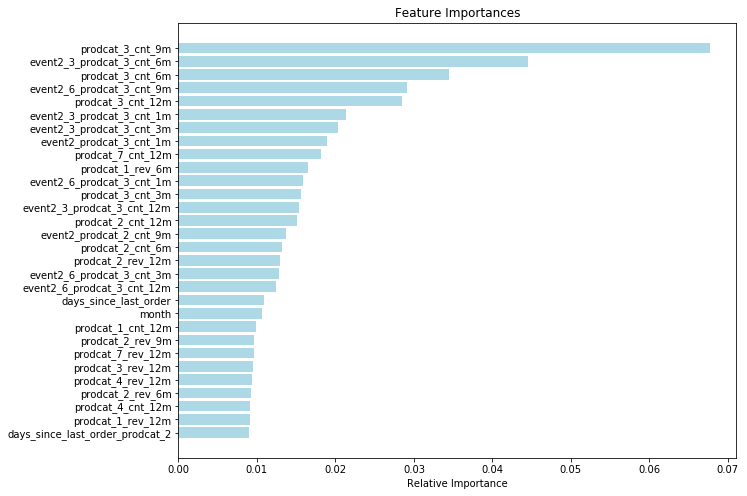

In [691]:
features = X.columns
importances = cl0.feature_importances_
indices = np.argsort(importances)[-30:]  # top 30 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gcf().set_size_inches((10, 8)) 
plt.show()

#### Checking correlation matrix

In [800]:
#order_base_2017.corr()

#### highly correlated variables
Positive:
- count & revenue
- 3/6/9/12 months
- Total event2 & event 2 type 7

In [ ]:
temp = order_base_2017.corr().stack().to_frame().reset_index()
#temp[temp[0].abs()<0.76].sort_values(by=0, ascending=False)[:100]

Negative:
- days since last order & ever_3/6/9/12m

In [796]:
#temp[temp[0].abs()<1].sort_values(by=0, ascending=True)[:60]

#### Trial 1 with 229 variables (1/3/6/9/12m)

In [697]:
cl1 = xgb.XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.05)     
cl1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [698]:
y_pred = cl1.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print ('Accuracy = ' , accuracy_score(y_test, y_pred))
print ("Classification Report\n")
print (classification_report(y_test, y_pred))

[[ 662 1430  362  274   44   27]
 [ 216 4126  442  357   24   17]
 [ 174 1191 1427  224   29   27]
 [ 137 1121  279  928   30   10]
 [ 140  262  120  109  132   11]
 [ 143  607  481  139   19   72]]
Accuracy =  0.46520610397011336
Classification Report

              precision    recall  f1-score   support

           1       0.45      0.24      0.31      2799
           2       0.47      0.80      0.59      5182
           3       0.46      0.46      0.46      3072
           4       0.46      0.37      0.41      2505
           5       0.47      0.17      0.25       774
           7       0.44      0.05      0.09      1461

   micro avg       0.47      0.47      0.47     15793
   macro avg       0.46      0.35      0.35     15793
weighted avg       0.46      0.47      0.42     15793



In [699]:
print(class_report(y_test, y_pred, cl1.predict_proba(X_test)))

             precision    recall  f1-score  support     pred       AUC
1             0.449728  0.236513  0.309998   2799.0   1472.0  0.735302
2             0.472244  0.796218  0.592859   5182.0   8737.0  0.756367
3             0.458695  0.464518  0.461588   3072.0   3111.0  0.758786
4             0.456918  0.370459  0.409171   2505.0   2031.0  0.773424
5             0.474820  0.170543  0.250951    774.0    278.0  0.858402
7             0.439024  0.049281  0.088615   1461.0    164.0  0.694301
avg / total   0.460240  0.465206  0.424653  15793.0  15793.0  0.800375


In [705]:
temp = class_report(y_test, y_pred, cl1.predict_proba(X_test))
AUC_trial1 = temp['AUC']['avg / total']

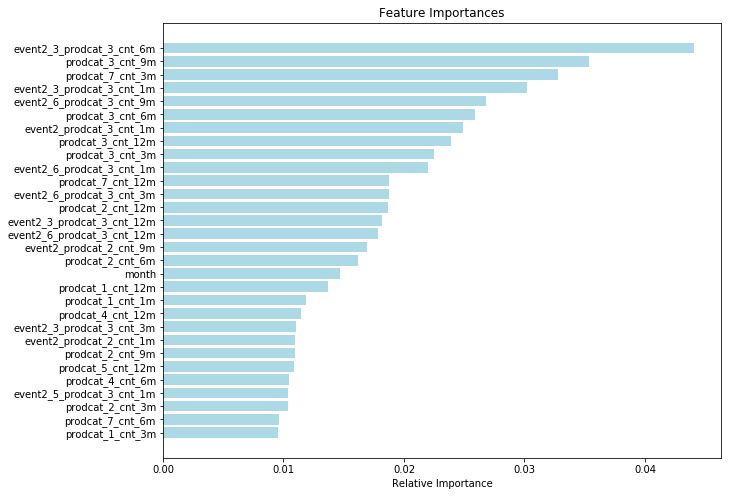

In [701]:
features = X.columns
importances = cl1.feature_importances_
indices = np.argsort(importances)[-30:]  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gcf().set_size_inches((10, 8)) 
plt.show()

#### Trial 2 with 88 variables ( only 1m & 3m)

In [720]:
cl2 = xgb.XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.05)     
cl2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [721]:
y_pred = cl2.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print ('Accuracy = ' , accuracy_score(y_test, y_pred))
print ("Classification Report\n")
print (classification_report(y_test, y_pred))

[[ 693 1434  351  287   28    6]
 [ 265 4064  464  355   24   10]
 [ 186 1312 1280  254   20   20]
 [ 165 1188  251  870   27    4]
 [ 174  268  111  113   97   11]
 [ 161  650  469  133   14   34]]
Accuracy =  0.4456404736275565
Classification Report

              precision    recall  f1-score   support

           1       0.42      0.25      0.31      2799
           2       0.46      0.78      0.58      5182
           3       0.44      0.42      0.43      3072
           4       0.43      0.35      0.39      2505
           5       0.46      0.13      0.20       774
           7       0.40      0.02      0.04      1461

   micro avg       0.45      0.45      0.45     15793
   macro avg       0.43      0.32      0.32     15793
weighted avg       0.44      0.45      0.40     15793



In [722]:
print(class_report(y_test, y_pred, cl2.predict_proba(X_test)))

             precision    recall  f1-score  support     pred       AUC
1             0.421533  0.247588  0.311951   2799.0   1644.0  0.707444
2             0.455810  0.784253  0.576536   5182.0   8916.0  0.730717
3             0.437457  0.416667  0.426809   3072.0   2926.0  0.729569
4             0.432406  0.347305  0.385211   2505.0   2012.0  0.751222
5             0.461905  0.125323  0.197154    774.0    210.0  0.844898
7             0.400000  0.023272  0.043984   1461.0     85.0  0.674529
avg / total   0.437589  0.445640  0.402313  15793.0  15793.0  0.781478


In [725]:
temp = class_report(y_test, y_pred, cl2.predict_proba(X_test))
AUC_trial2 = temp['AUC']['avg / total']

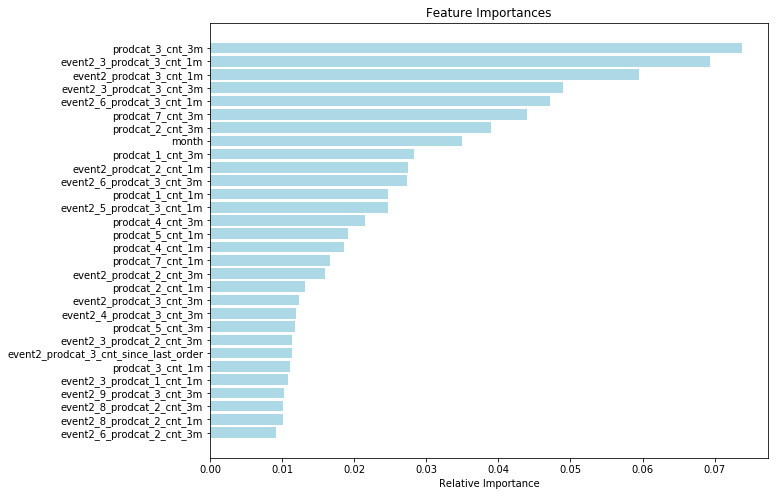

In [723]:
features = X.columns
importances = cl2.feature_importances_
indices = np.argsort(importances)[-30:]  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gcf().set_size_inches((10, 8)) 
plt.show()

#### Trial 3 with 131 variables (1/6/12m)

In [732]:
cl3 = xgb.XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.05)     
cl3.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [733]:
y_pred = cl3.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print ('Accuracy = ' , accuracy_score(y_test, y_pred))
print ("Classification Report\n")
print (classification_report(y_test, y_pred))

[[ 683 1406  357  276   46   31]
 [ 202 4122  448  363   29   18]
 [ 172 1189 1433  220   30   28]
 [ 133 1113  280  937   32   10]
 [ 141  266  119  110  127   11]
 [ 146  608  480  136   18   73]]
Accuracy =  0.4669790413474324
Classification Report

              precision    recall  f1-score   support

           1       0.46      0.24      0.32      2799
           2       0.47      0.80      0.59      5182
           3       0.46      0.47      0.46      3072
           4       0.46      0.37      0.41      2505
           5       0.45      0.16      0.24       774
           7       0.43      0.05      0.09      1461

   micro avg       0.47      0.47      0.47     15793
   macro avg       0.46      0.35      0.35     15793
weighted avg       0.46      0.47      0.43     15793



In [734]:
print(class_report(y_test, y_pred, cl3.predict_proba(X_test)))

             precision    recall  f1-score  support     pred       AUC
1             0.462424  0.244016  0.319457   2799.0   1477.0  0.733754
2             0.473575  0.795446  0.593691   5182.0   8704.0  0.755471
3             0.459737  0.466471  0.463080   3072.0   3117.0  0.758833
4             0.458864  0.374052  0.412140   2505.0   2042.0  0.774290
5             0.450355  0.164083  0.240530    774.0    282.0  0.857218
7             0.426901  0.049966  0.089461   1461.0    171.0  0.693890
avg / total   0.461118  0.466979  0.426932  15793.0  15793.0  0.800217


In [736]:
temp = class_report(y_test, y_pred, cl3.predict_proba(X_test))
AUC_trial3 = temp['AUC']['avg / total']

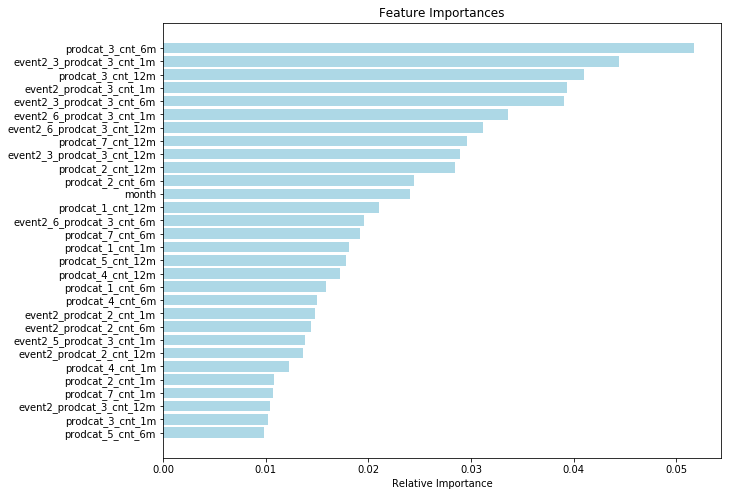

In [735]:
features = X.columns
importances = cl3.feature_importances_
indices = np.argsort(importances)[-30:]  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gcf().set_size_inches((10, 8)) 
plt.show()

#### Trial 4 with 88 variables (1/6m)

In [743]:
cl4 = xgb.XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.05)     
cl4.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [744]:
y_pred = cl4.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print ('Accuracy = ' , accuracy_score(y_test, y_pred))
print ("Classification Report\n")
print (classification_report(y_test, y_pred))

[[ 673 1433  358  289   32   14]
 [ 262 4092  442  352   22   12]
 [ 181 1219 1400  229   24   19]
 [ 169 1131  268  901   25   11]
 [ 172  269  120  112   91   10]
 [ 163  620  471  134   13   60]]
Accuracy =  0.4569746090039891
Classification Report

              precision    recall  f1-score   support

           1       0.42      0.24      0.30      2799
           2       0.47      0.79      0.59      5182
           3       0.46      0.46      0.46      3072
           4       0.45      0.36      0.40      2505
           5       0.44      0.12      0.19       774
           7       0.48      0.04      0.08      1461

   micro avg       0.46      0.46      0.46     15793
   macro avg       0.45      0.33      0.33     15793
weighted avg       0.45      0.46      0.41     15793



In [745]:
print(class_report(y_test, y_pred, cl4.predict_proba(X_test)))

             precision    recall  f1-score  support     pred       AUC
1             0.415432  0.240443  0.304594   2799.0   1620.0  0.719090
2             0.466910  0.789657  0.586835   5182.0   8764.0  0.744180
3             0.457666  0.455729  0.456695   3072.0   3059.0  0.747471
4             0.446703  0.359681  0.398496   2505.0   2017.0  0.762682
5             0.439614  0.117571  0.185525    774.0    207.0  0.843746
7             0.476190  0.041068  0.075614   1461.0    126.0  0.685203
avg / total   0.452304  0.456975  0.414665  15793.0  15793.0  0.790321


In [789]:
temp = class_report(y_test, y_pred, cl4.predict_proba(X_test))
AUC_trial4 = temp['AUC']['avg / total']

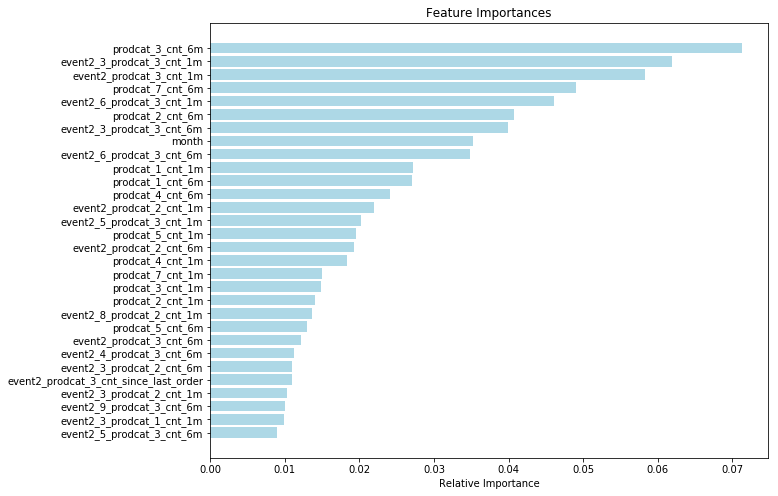

In [747]:
features = X.columns
importances = cl4.feature_importances_
indices = np.argsort(importances)[-30:]  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gcf().set_size_inches((10, 8)) 
plt.show()

#### Trial 5 with 46 variables (1m)

In [776]:
cl5 = xgb.XGBClassifier(max_depth=3, n_estimators=200, learning_rate=0.05)     
cl5.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [777]:
y_pred = cl5.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print ('Accuracy = ' , accuracy_score(y_test, y_pred))
print ("Classification Report\n")
print (classification_report(y_test, y_pred))

[[ 678 1465  313  295   38   10]
 [ 348 3975  451  365   32   11]
 [ 235 1390 1129  283   27    8]
 [ 178 1203  220  872   26    6]
 [ 198  248   96  121   98   13]
 [ 196  667  415  136   14   33]]
Accuracy =  0.4296207180396378
Classification Report

              precision    recall  f1-score   support

           1       0.37      0.24      0.29      2799
           2       0.44      0.77      0.56      5182
           3       0.43      0.37      0.40      3072
           4       0.42      0.35      0.38      2505
           5       0.42      0.13      0.19       774
           7       0.41      0.02      0.04      1461

   micro avg       0.43      0.43      0.43     15793
   macro avg       0.41      0.31      0.31     15793
weighted avg       0.42      0.43      0.39     15793



In [778]:
print(class_report(y_test, y_pred, cl5.predict_proba(X_test)))

             precision    recall  f1-score  support     pred       AUC
1             0.369885  0.242229  0.292746   2799.0   1833.0  0.678643
2             0.444233  0.767078  0.562633   5182.0   8948.0  0.705081
3             0.430259  0.367513  0.396419   3072.0   2624.0  0.696550
4             0.420849  0.348104  0.381036   2505.0   2072.0  0.737726
5             0.417021  0.126615  0.194252    774.0    235.0  0.842252
7             0.407407  0.022587  0.042802   1461.0     81.0  0.655253
avg / total   0.419889  0.429621  0.387522  15793.0  15793.0  0.766044


In [780]:
temp = class_report(y_test, y_pred, cl5.predict_proba(X_test))
AUC_trial5 = temp['AUC']['avg / total']

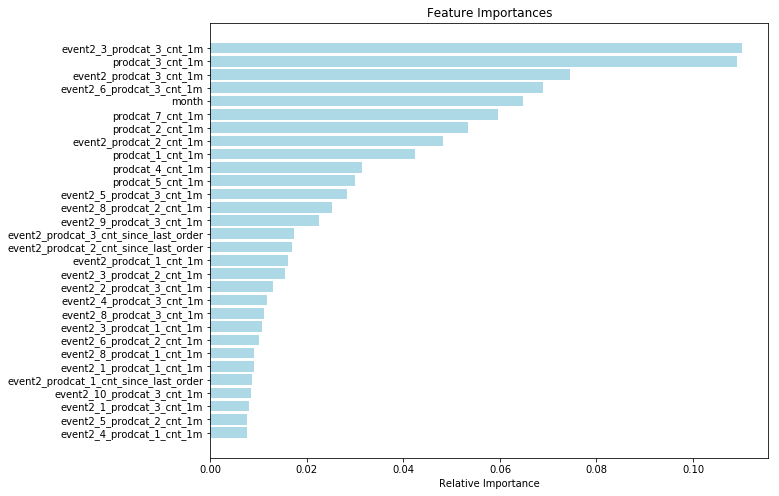

In [781]:
features = X.columns
importances = cl5.feature_importances_
indices = np.argsort(importances)[-30:]  # top 20 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='lightblue', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.gcf().set_size_inches((10, 8)) 
plt.show()

## 3.3 Evaluation Across Models  <a id='M-eval'></a>

     1,3,6,9,12 m  1,6,12 m     1,6 m     1,3 m        1m
AUC      0.800375  0.800217  0.790321  0.781478  0.766044


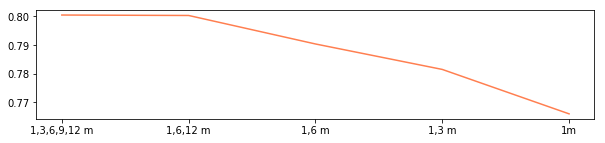

In [793]:
x = ['1,3,6,9,12 m', '1,6,12 m', '1,6 m', '1,3 m', '1m']
y = [AUC_trial1, AUC_trial3, AUC_trial4, AUC_trial2, AUC_trial5]
index = ['AUC']

plt.gcf().set_size_inches((10, 2)) 
plt.plot(x, y, color='coral')
print(pd.DataFrame([y], columns=x, index=index))

## 4 Summary of Results     <a id='Summary'></a>

#### Overall  Sales Performance:
- Revenue in 2018 went down: revenue for prodcat 2 dropped; meanwhile, 3 and 7 grew up.
- Each year, new comers accounts for over 80% of the customers and contributed over 50% of the annual revenue.


#### Customer Purchase Pattern:
- Over 80% of the orders contained only one product category: category 2 (26%) was the most; 1 (16%), 3 (15%), 4 (15%) came after.
- Purchased category combination did not shift much overtime; however, category 2 trended down and the combination of 3 and 7 went up.
- Overall purchase season peaked in January and fell in October. 
    - Orders for category 2 is the most popular during a year, except for October to December; whereas, category 1 is the most popular during November to December.

#### Key Features to Predict next product-category-to-buy:
- Past behaviors are the best predictors:
    - Number of <u>purchased item counts</u> for specific product category within X months
    - Number of <u>events type 3 and 6</u> for specific product category within X months
- Interesting finding:
    - Although competing with lots of behavioral variables, <u>the month of order</u> was also selected as an important feature.

#### Model Evaluation:
- Overall <u>AUC score</u> across different models are <u>between 76~80%, with 42~46% precision rate and 43~47% recall rate</u>.
    - Aligning with the intuition, <u>the longer the observation period, the better the prediction</u>.
    - However, considering computed time and resources, I suggest to <u>go for shorter observation period and try tuning the model to improve AUC</u>.

#### Model Tuning Opportunities:
- Try different ML models and adjust hyper-parameters to improve model performance.
- Build seperate models for different customer segments: 
    - eg. <u>First-time vs. existing customer</u>: data available and observing period would be different; features selected by model would also change.

